In [1]:
!pip install --no-deps tensorflowjs
import tensorflowjs as tfjs

     |████████████████████████████████| 77 kB 2.5 MB/s 


In [2]:
# Só deve descomentar 1 opção
#origemImagens = 'originais'
origemImagens = 'originaisLimpas'
#origemImagens = 'aumentoDeDados'
#origemImagens = 'aumentoDeDadosLimpas'

In [3]:
dicionarioNomesArquivos = {
    'originais': ('dataset.csv', 'labels.csv'),
    'originaisLimpas': ('datasetLimpo.csv', 'labelsLimpo.csv'),
    'aumentoDeDados': ('datasetExpandido.csv', 'labelsExpandido.csv'),
    'aumentoDeDadosLimpas': ('datasetExpandidoLimpo.csv', 'labelsExpandidoLimpo.csv'),
}
(nomeArquivoDataset, nomeArquivoLabels) = dicionarioNomesArquivos[origemImagens]

In [4]:
# Paths para dados
datasetPath = '/content/drive/MyDrive/2021.2/TCC/Testes/Data/DatasetMultiprova/LetrasVF/' + nomeArquivoDataset
labelsPath = '/content/drive/MyDrive/2021.2/TCC/Testes/Data/DatasetMultiprova/LetrasVF/' + nomeArquivoLabels
pathToModel = '/content/drive/MyDrive/2021.2/TCC/Modelos/VouF3Canais/Base'
pathToModelJs = '/content/drive/MyDrive/2021.2/TCC/Modelos/VouF3Canais/Js'

In [5]:
shapeImg = (32, 32, 3)
quantidadeDeCanais = shapeImg[2]
quantidadeDeClasses = 3

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import numpy as np
import pandas as pd
import string
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.interpolate import make_interp_spline

In [8]:
def countSamplesByClass(df):
  lettersCount = Counter(df)
  plt.figure(figsize=(10,10))
  plt.barh(list(lettersCount.keys()), list(lettersCount.values()))
  plt.title('Quantidade de amostras por letras')
  plt.xlabel('Quantidade de amostras')
  plt.ylabel('Letras')
  plt.show()

In [9]:
def createSpline(x, y):
  X_Y_Spline = make_interp_spline(x, y)
  X_ = np.linspace(min(x), max(x), 500)
  Y_ = X_Y_Spline(X_)
  return (X_, Y_)

In [10]:
def formatFigure(plt):
  plt.grid(False)
  plt.axvline(x=0, c="black", linewidth=1)
  plt.axhline(y=0, xmin=0.05, c="black", linewidth=2)
  ax = plt.gca()
  ax.set_ylim([0, 1.025])
  ax.set_facecolor('white')
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)

In [11]:
letters = ['F', 'V', '10']
numbersToLetters = {}
lettersToNumbers = {}
for (index, letter) in enumerate(letters):
  lettersToNumbers[letter] = index
  numbersToLetters[index] = letter
print(numbersToLetters)
print(lettersToNumbers)

{0: 'F', 1: 'V', 2: '10'}
{'F': 0, 'V': 1, '10': 2}


In [12]:
# Carregar dados
dataframe = pd.read_csv(datasetPath).astype('float32')
labels = pd.read_csv(labelsPath, squeeze=True).astype('string')

In [13]:
print('Quantidade de amostras:', len(labels))

Quantidade de amostras: 4895


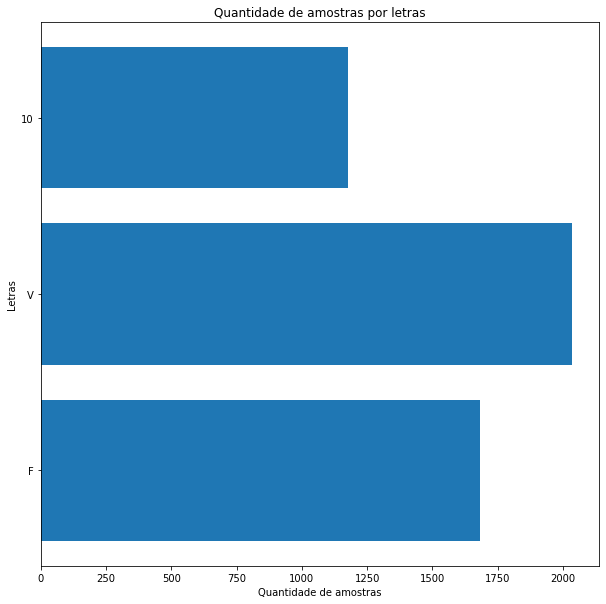

In [14]:
countSamplesByClass(labels)

In [15]:
dataframeNumpy = dataframe.to_numpy()
dataframeShapeImg = dataframeNumpy.reshape(dataframe.shape[0], shapeImg[0], shapeImg[1], quantidadeDeCanais).astype('float32')

In [16]:
labelsInNumbers = labels.map(lettersToNumbers) 
labelsFormatedToCNN = to_categorical(labelsInNumbers, quantidadeDeClasses) # CNN nao binaria

In [17]:
#dataframeTrain, dataframeTemp, labelsTrain, labelsTemp = train_test_split(dataframeShapeImg, labelsInNumbers, test_size=0.3, random_state=42) # CNN binaria
dataframeTrain, dataframeTemp, labelsTrain, labelsTemp = train_test_split(dataframeShapeImg, labelsFormatedToCNN, test_size=0.3, random_state=42) # CNN nao binaria
dataframeTest, dataframeVal, labelsTest, labelsVal = train_test_split(dataframeTemp, labelsTemp, test_size=0.5, random_state=42)

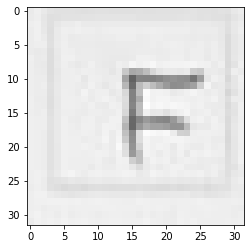

Index: 404 , Label: F


In [18]:
# Checar se imagem corresponde a label correta
randomIndex = random.randint(0, len(labelsTrain))
testImg = dataframeTrain[randomIndex]
testImg = np.array(testImg).reshape(shapeImg[0], shapeImg[1], quantidadeDeCanais)
plt.imshow(testImg, cmap="gray")
plt.show()
print('Index:', randomIndex, ', Label:', labels[randomIndex])

In [34]:
# Criar estrutura da CNN
CNN = Sequential()
CNN.add(Conv2D(32, kernel_size=(3, 3), input_shape=(shapeImg[0], shapeImg[1], quantidadeDeCanais), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Flatten())
CNN.add(Dense(64, activation='relu'))
#CNN.add(Dense(1, activation='sigmoid')) # CNN binaria
CNN.add(Dense(quantidadeDeClasses, activation='softmax')) # CNN nao binaria
#CNN.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=['accuracy']) # CNN binaria
CNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # CNN nao binaria

In [ ]:
# (OPCIONAL) Resumo da CNN
CNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [35]:
epochs = 15
history = CNN.fit(dataframeTrain, labelsTrain, validation_data=(dataframeVal, labelsVal), epochs=epochs, verbose=2)

Epoch 1/15
108/108 - 2s - loss: 0.5609 - accuracy: 0.7417 - val_loss: 0.1699 - val_accuracy: 0.9497 - 2s/epoch - 15ms/step
Epoch 2/15
108/108 - 1s - loss: 0.1510 - accuracy: 0.9568 - val_loss: 0.0560 - val_accuracy: 0.9850 - 766ms/epoch - 7ms/step
Epoch 3/15
108/108 - 1s - loss: 0.0453 - accuracy: 0.9848 - val_loss: 0.0263 - val_accuracy: 0.9918 - 846ms/epoch - 8ms/step
Epoch 4/15
108/108 - 1s - loss: 0.0221 - accuracy: 0.9936 - val_loss: 0.0185 - val_accuracy: 0.9946 - 811ms/epoch - 8ms/step
Epoch 5/15
108/108 - 1s - loss: 0.0208 - accuracy: 0.9945 - val_loss: 0.0198 - val_accuracy: 0.9946 - 1s/epoch - 10ms/step
Epoch 6/15
108/108 - 1s - loss: 0.0149 - accuracy: 0.9953 - val_loss: 0.0105 - val_accuracy: 0.9973 - 842ms/epoch - 8ms/step
Epoch 7/15
108/108 - 1s - loss: 0.0108 - accuracy: 0.9962 - val_loss: 0.0197 - val_accuracy: 0.9932 - 775ms/epoch - 7ms/step
Epoch 8/15
108/108 - 1s - loss: 0.0223 - accuracy: 0.9918 - val_loss: 0.0118 - val_accuracy: 0.9959 - 771ms/epoch - 7ms/step
Epoc

In [36]:
scores = CNN.evaluate(dataframeTest, labelsTest, verbose=0)
print("CNN Score:", '{}%'.format(scores[1] * 100))
print("Scores: ", scores)

CNN Score: 99.59127902984619%
Scores:  [0.004827567841857672, 0.9959127902984619]


In [43]:
# (OPCIONAL) Salvar modelo
CNN.save(pathToModel)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/2021.2/TCC/Modelos/VouF3Canais/Base/assets


In [44]:
# (OPCIONAL) Exportar modelo para tensorflowJs
tfjs.converters.save_keras_model(CNN, pathToModelJs)

In [37]:
# Array de valores em X para tracar a spline dos gráficos
xAxis = [index for index in range(0, epochs)]

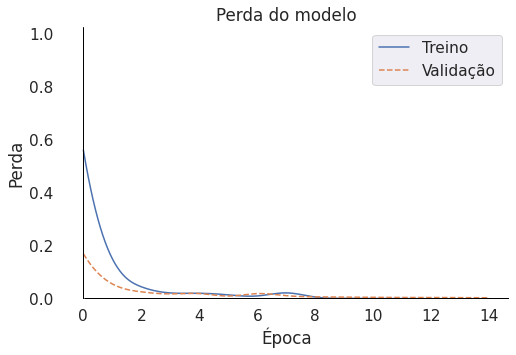

In [38]:
# (OPCIONAL) Gráfico de perda
Xloss, Yloss = createSpline(xAxis, history.history['loss'])
Xvalloss, Yvalloss = createSpline(xAxis, history.history['val_loss'])
plt.figure(figsize=(8, 5))
plt.plot(Xloss, Yloss)
plt.plot(Xvalloss, Yvalloss, '--')
formatFigure(plt)
plt.title('Perda do modelo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.show()

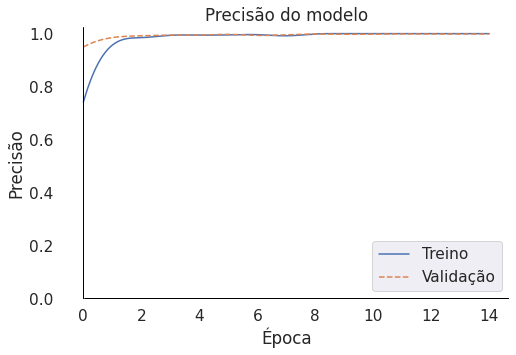

In [39]:
# (OPCIONAL) Gráfico de precisão
plt.figure(figsize=(8, 5))
Xacc, Yacc = createSpline(xAxis, history.history['accuracy'])
Xvalacc, Yvalacc = createSpline(xAxis, history.history['val_accuracy'])
plt.plot(Xacc, Yacc)
plt.plot(Xvalacc, Yvalacc, '--')
formatFigure(plt)
plt.title('Precisão do modelo')
plt.ylabel('Precisão')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='lower right')
plt.show()

In [ ]:
#results = CNN.predict(dataframeTest) # CNN binaria
#roundedResults = [int(np.round(num)) for num in results] # CNN binaria

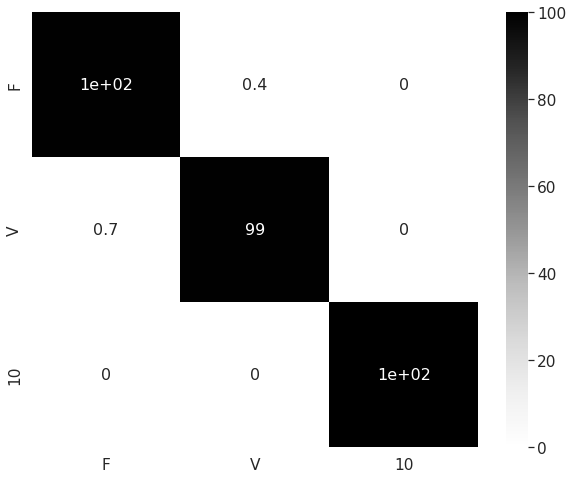

In [40]:
#cm = confusion_matrix(labelsTest, roundedResults, normalize='true') * 100 # CNN binaria
cm = confusion_matrix(labelsTest.argmax(axis=1), CNN.predict(dataframeTest).argmax(axis=1), normalize='true') * 100 # CNN nao binaria
cmRounded = [[round(num, 1) for num in line] for line in cm]
df_cm = pd.DataFrame(cmRounded, letters, letters)
plt.figure(figsize = (10, 8))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Greys')

In [ ]:
# (OPCIONAL) Carregar modelo
CNN = load_model(pathToModel)

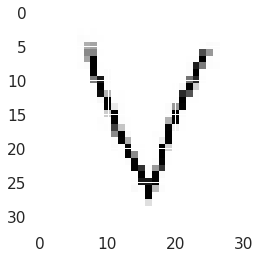

V 100.0%
[1.4532363e-16 1.0000000e+02 0.0000000e+00]


In [42]:
# (OPCIONAL) Carregar imagem e testar predição
pathToImg = '/content/drive/MyDrive/2021.2/TCC/Testes/Data/Letras/V_1.jpg'
baseImg = cv2.imread(pathToImg, cv2.IMREAD_COLOR)
maxColorBaseImg = max(baseImg.flatten())
baseImgNormalized = baseImg / maxColorBaseImg
resizedBaseImage = cv2.resize(baseImgNormalized, (shapeImg[0], shapeImg[1]))

testImage = np.array(resizedBaseImage).reshape(-1, shapeImg[0], shapeImg[1], quantidadeDeCanais)
plt.imshow(resizedBaseImage)
plt.show()
y_predicted = CNN.predict(testImage)
predictScores = y_predicted[0] * 100
winnerIdx = np.argmax(predictScores)
print(numbersToLetters[winnerIdx], '{}%'.format(predictScores[winnerIdx]))
print(predictScores)